## Load modules

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import glob
import math
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from PIL import Image
from geometry import extract_feature_pixels_lowest_region, focal_length_to_pixels, calculate_height_difference_perspective, estimate_Z_for_points,estimate_FFH
from pyproj import Transformer
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

## Set input and output folders

In [4]:
in_folder_predictions=r'D:\Wagga\RICS\all_images_predicted'
building_point_file=r'D:\Wagga\RICS\Final_Wagga_meta.geojson'
building_footprint_file=r'C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\GA-floor-height\data\wagga_building.gpkg'

## Read in building points and footprint datasets

In [5]:
gdf_points=gpd.read_file(building_point_file)
gdf_points.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,fix_quality,camera_ID,index,lon,lat,distance,relative_angle,RICS_img,Floor_height,geometry
0,Brick,1,Residential,1,NEIL,80 THORNE STREET,339.307232,4.1541,0.9867,-9999.0,...,1.0,108246.0,7341.0,147.363508,-35.113159,27.921232,0.930013,old_res_131112_33816_R_0007341.jpg,0.28,POINT (533121.036 6114319.815)
1,Timber,1,Residential,1,NEIL,156 FORSYTH STREET,261.009733,5.5493,-9999.0000,-9999.0,...,1.0,108246.0,7304.0,147.362419,-35.113016,32.240570,0.058193,old_res_131112_33816_R_0007304.jpg,0.28,POINT (533021.042 6114331.849)
2,Brick,1,Residential,1,NEIL,42 BEST STREET,193.217477,2.8469,-9999.0000,-9999.0,...,1.0,108246.0,2051.0,147.366291,-35.116350,34.089616,0.710337,old_res_131112_33816_R_0002051.jpg,0.28,POINT (533343.734 6113998.271)
3,Brick,1,Residential,1,NEIL,29 FOX STREET,168.814975,2.5406,-9999.0000,-9999.0,...,1.0,53046.0,8523.0,147.364759,-35.116503,31.763384,2.518713,old_res_131112_33816_L_0008523.jpg,0.28,POINT (533269.26 6113972.736)
4,Brick,1,Residential,1,NEIL,150 FORSYTH STREET,340.008460,5.3143,1.2041,-9999.0,...,1.0,108246.0,7321.0,147.362935,-35.113083,36.840376,1.993235,old_res_131112_33816_R_0007321.jpg,0.28,POINT (533066.072 6114319.908)


In [6]:
gdf_footprint=gpd.read_file(building_footprint_file).to_crs(gdf_points.crs)
gdf_footprint.head()

,min_height_ahd,max_height_ahd,geometry
0,260.380,261.404,"POLYGON ((526929.366 6108227.811, 526923.327 6..."
1,263.089,264.092,"POLYGON ((526932.949 6108256.742, 526929.971 6..."
2,262.491,262.949,"POLYGON ((526972.892 6108265.607, 526967.864 6..."
3,264.359,264.692,"POLYGON ((527037.881 6108335.54, 527034.092 61..."
4,277.474,277.954,"POLYGON ((526490.129 6108485.901, 526482.165 6..."


## Read in segmentation predictions from OneFormer

In [7]:
prediction_files = glob.glob(os.path.join(in_folder_predictions,'*.png'))
prediction_file=prediction_files[0]
lbl_arr = np.asarray(Image.open(prediction_file))

In [8]:
RICS_id=os.path.basename(prediction_file).split('.')[0]
print(RICS_id)

cbd_141112_11404_R_0002134


## Find nearest building footprint

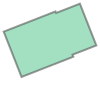

In [9]:
RICS_str=RICS_id+'.jpg'
building_point = gdf_points[gdf_points['RICS_img'] == RICS_str].iloc[0]
# Find the nearest polygon
point_geom = building_point.geometry  # Extract the geometry of the selected point
nearest_polygon = gdf_footprint.loc[gdf_footprint.distance(point_geom).idxmin()]
closest_polygon_geom = nearest_polygon.geometry
closest_polygon_geom

## Get RICS image coordinates

In [10]:
camera_lat=building_point['lat']
camera_lon=building_point['lon']
camera_position=Point(camera_lon,camera_lat)
transfomer=Transformer.from_crs("EPSG:4326",gdf_points.crs,always_xy=True)
x,y=transfomer.transform(camera_position.x,camera_position.y)
camera_position_tranformed=Point(x,y)

## Convert focal length from mm to pixels

In [11]:
H_img = lbl_arr.shape[0]  # Height of image
# Camera and image parameters
focal_length_mm = 8.5  # Focal length in mm
sensor_width_mm = 8.8  # Sensor width in mm (for AVT GC2450 camera)
image_width_px = 2448  # Image width in pixels
image_height_px = 2050  # Image height in pixels

# Convert focal length to pixels
focal_length_px = focal_length_to_pixels(focal_length_mm, sensor_width_mm, image_width_px)
print(f"Focal length in pixels: {focal_length_px:.2f}")

Focal length in pixels: 2364.55


## Extract feature top/bottom pixels

In [12]:
# extract bottom pixels of foundation, stairs, front door and garage door
foundation_mask=(lbl_arr==1)
frontdoor_mask = (lbl_arr==2)
garagedoor_mask = (lbl_arr==3)
stairs_mask = (lbl_arr==4)
foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

# extract top pixels of foundation and stairs
foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

## Calculate distances from camera to features

In [13]:
# Estimate Z distances for the image points
distances_foundation_bottom, y_coords_foundation_bottom=estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, foundation_bottom_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)
distances_stairs_bottom, y_coords_stairs_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, stairs_bottom_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)
distances_frontdoor_bottom, y_coords_frontdoor_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, frontdoor_bottom_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)
distances_garagedoor_bottom, y_coords_garagedoor_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, garagedoor_bottom_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)

distances_foundation_top, y_coords_foundation_top = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, foundation_top_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)
distances_stairs_top, y_coords_stairs_top = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                camera_position_tranformed, stairs_top_pixels, 
                                focal_length_px, sensor_width_mm, image_width_px)

## Calculate height difference between features to centre of view

In [14]:
delta_foundation_bottom=calculate_height_difference_perspective(y_coords_foundation_bottom, distances_foundation_bottom,focal_length_px, image_height_px)
delta_stairs_bottom=calculate_height_difference_perspective(y_coords_stairs_bottom, distances_stairs_bottom,focal_length_px, image_height_px)
delta_frontdoor_bottom=calculate_height_difference_perspective(y_coords_frontdoor_bottom, distances_frontdoor_bottom,focal_length_px, image_height_px)
delta_garagedoor_bottom=calculate_height_difference_perspective(y_coords_garagedoor_bottom, distances_garagedoor_bottom,focal_length_px, image_height_px)
delta_foundation_top=calculate_height_difference_perspective(y_coords_foundation_top, distances_foundation_top,focal_length_px, image_height_px)
delta_stairs_top=calculate_height_difference_perspective(y_coords_stairs_top, distances_stairs_top,focal_length_px, image_height_px)

## Estimate FFH

In [15]:
FFH = estimate_FFH(elev_foundation_top=delta_foundation_top, 
                   elev_foundation_bottom=delta_foundation_bottom,
                   elev_stairs_top=delta_stairs_top, 
                   elev_stairs_bottom=delta_stairs_bottom, 
                   elev_frontdoor_bottom=delta_frontdoor_bottom,
                   elev_garagedoor_bottom=delta_garagedoor_bottom, 
                   elev_camera=None)
print("Estimated First Floor Height (FFH):", FFH)

Estimated First Floor Height (FFH): 0


## Batch calculate for all images

In [16]:
FFH_all_predicted=[]
RICS_strs=[]
# prediction_file=prediction_files[0]
for prediction_file in prediction_files:
    lbl_arr = np.asarray(Image.open(prediction_file))
    RICS_id=os.path.basename(prediction_file).split('.')[0]
    print(RICS_id)
    RICS_str=RICS_id+'.jpg'
    RICS_strs.append(RICS_str)
    building_point = gdf_points[gdf_points['RICS_img'] == RICS_str].iloc[0]

    # Find the nearest polygon
    point_geom = building_point.geometry  # Extract the geometry of the selected point
    nearest_polygon = gdf_footprint.loc[gdf_footprint.distance(point_geom).idxmin()]
    closest_polygon_geom = nearest_polygon.geometry
    camera_lat=building_point['lat']
    camera_lon=building_point['lon']
    camera_position=Point(camera_lon,camera_lat)
    transfomer=Transformer.from_crs("EPSG:4326",gdf_points.crs,always_xy=True)
    x,y=transfomer.transform(camera_position.x,camera_position.y)
    camera_position_tranformed=Point(x,y)

    # extract bottom pixels of foundation, stairs, front door and garage door
    foundation_mask=(lbl_arr==1)
    frontdoor_mask = (lbl_arr==2)
    garagedoor_mask = (lbl_arr==3)
    stairs_mask = (lbl_arr==4)
    foundation_bottom_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="bottom")
    stairs_bottom_pixels = extract_feature_pixels_lowest_region(stairs_mask, extract="bottom")
    frontdoor_bottom_pixels = extract_feature_pixels_lowest_region(frontdoor_mask,extract="bottom")
    garagedoor_bottom_pixels = extract_feature_pixels_lowest_region(garagedoor_mask,extract="bottom")

    # extract top pixels of foundation and stairs
    foundation_top_pixels = extract_feature_pixels_lowest_region(foundation_mask,extract="top")
    stairs_top_pixels = extract_feature_pixels_lowest_region(stairs_mask,extract="top")

    # Estimate Z distances for the image points
    distances_foundation_bottom, y_coords_foundation_bottom=estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, foundation_bottom_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)
    distances_stairs_bottom, y_coords_stairs_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, stairs_bottom_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)
    distances_frontdoor_bottom, y_coords_frontdoor_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, frontdoor_bottom_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)
    distances_garagedoor_bottom, y_coords_garagedoor_bottom = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, garagedoor_bottom_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)

    distances_foundation_top, y_coords_foundation_top = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, foundation_top_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)
    distances_stairs_top, y_coords_stairs_top = estimate_Z_for_points(closest_polygon_geom, point_geom, 
                                    camera_position_tranformed, stairs_top_pixels, 
                                    focal_length_px, sensor_width_mm, image_width_px)

    delta_foundation_bottom=calculate_height_difference_perspective(y_coords_foundation_bottom, distances_foundation_bottom,focal_length_px, image_height_px)
    delta_stairs_bottom=calculate_height_difference_perspective(y_coords_stairs_bottom, distances_stairs_bottom,focal_length_px, image_height_px)
    delta_frontdoor_bottom=calculate_height_difference_perspective(y_coords_frontdoor_bottom, distances_frontdoor_bottom,focal_length_px, image_height_px)
    delta_garagedoor_bottom=calculate_height_difference_perspective(y_coords_garagedoor_bottom, distances_garagedoor_bottom,focal_length_px, image_height_px)
    delta_foundation_top=calculate_height_difference_perspective(y_coords_foundation_top, distances_foundation_top,focal_length_px, image_height_px)
    delta_stairs_top=calculate_height_difference_perspective(y_coords_stairs_top, distances_stairs_top,focal_length_px, image_height_px)

    FFH = estimate_FFH(elev_foundation_top=delta_foundation_top, 
                    elev_foundation_bottom=delta_foundation_bottom,
                    elev_stairs_top=delta_stairs_top, 
                    elev_stairs_bottom=delta_stairs_bottom, 
                    elev_frontdoor_bottom=delta_frontdoor_bottom,
                    elev_garagedoor_bottom=delta_garagedoor_bottom, 
                    elev_camera=None)
    FFH_all_predicted.append(FFH)
    print("Estimated First Floor Height (FFH):", FFH)

cbd_141112_11404_R_0002134
Estimated First Floor Height (FFH): 0
cbd_141112_11404_R_0002129
Estimated First Floor Height (FFH): 0.9462883446573347
cbd_141112_11404_R_0002140
Estimated First Floor Height (FFH): 0
cbd_141112_11404_R_0002162
Estimated First Floor Height (FFH): 0
cbd_141112_11404_L_0000480
Estimated First Floor Height (FFH): 0.5004055003595589
cbd_141112_11404_L_0000755
Estimated First Floor Height (FFH): 0
cbd_141112_11404_L_0002222
Estimated First Floor Height (FFH): 0
cbd_141112_11404_R_0002816
Estimated First Floor Height (FFH): None
cbd_141112_11404_R_0005245
Estimated First Floor Height (FFH): 0
cbd_141112_11404_L_0000495
Estimated First Floor Height (FFH): 0
cbd_141112_11404_L_0002229
Estimated First Floor Height (FFH): 0
old_res_131112_33816_L_0002099
Estimated First Floor Height (FFH): 0
cbd_141112_11404_R_0004375
Estimated First Floor Height (FFH): 0
cbd_141112_11404_L_0000543
Estimated First Floor Height (FFH): 0.42144975228310244
cbd_141112_11404_L_0001086
Esti

## Write back to building points

In [17]:
gdf_updated=gdf_points.copy()
RICS_id_toFFH=dict(zip(RICS_strs, FFH_all_predicted))
gdf_updated["FFH_RICS"] = gdf_updated['RICS_img'].map(RICS_id_toFFH)
out_file=building_point_file.replace('.geojson','_FFH_RICS.geojson')
gdf_updated.to_file(out_file, driver="GeoJSON")

## Regression and accuracy assessment

c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\lliu\miniconda3\envs\floorheight\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


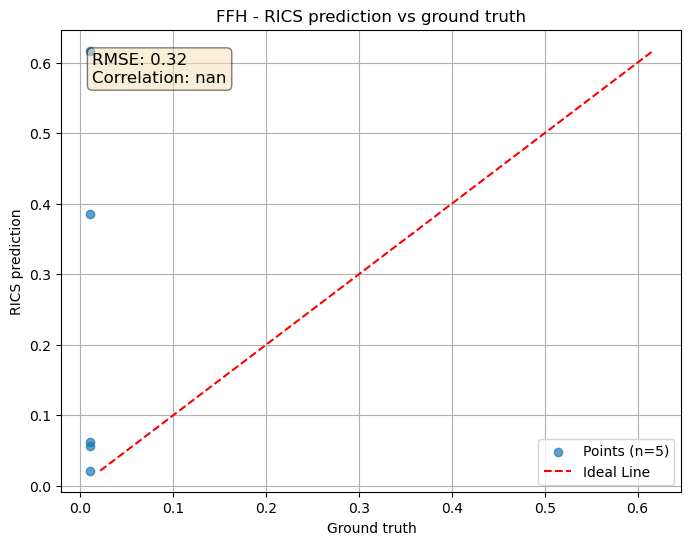

In [20]:
# Calculate RMSE
predicted=gdf_updated["FFH_RICS"]
gt=gdf_updated["Floor_height"]
# valid_indices = ~np.isnan(predicted) & ~np.isnan(gt) &(predicted!=0)
valid_indices = ~np.isnan(predicted) & ~np.isnan(gt) &(predicted!=0)& (gt!=0.28)
# valid_indices = ~np.isnan(predicted) & ~np.isnan(gt) & (gt!=0.28)
predicted = predicted[valid_indices]
gt = gt[valid_indices]

rmse = root_mean_squared_error(gt, predicted)
mae=mean_absolute_error(gt, predicted)
# Calculate Correlation Coefficient
correlation = np.corrcoef(predicted, gt)[0, 1]
# Plot scatter points
plt.figure(figsize=(8, 6))
plt.scatter(gt, predicted, alpha=0.7, label=f'Points (n={len(predicted)})')
# Add a line for ideal correlation (optional)
plt.plot([predicted.min(), predicted.max()],[predicted.min(), predicted.max()], 'r--', label='Ideal Line')
# Annotate RMSE and Correlation
plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nCorrelation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", fc="wheat", ec="black", alpha=0.5))
# Labeling
plt.title('FFH - RICS prediction vs ground truth')
plt.xlabel('Ground truth')
plt.ylabel('RICS prediction')
plt.legend()
plt.grid()
# Show plot
plt.show()

In [19]:
mae

0.4649782094614394